# Detecting seizure with DSOSD

# Configs

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils_dsosd import get_iEEG_data, detect_bad_channels, preprocess_for_detection

ieeg_user = 'joie1'
ieeg_pwd = '/mnt/sauce/littlab/users/kuangzy/DSOSD/ieeglogin.bin'
seizure_path = '/mnt/sauce/littlab/users/kuangzy/SeizureOnsetDetection/revised_emu_seizure_sheet.csv'
seizure_list = pd.read_csv(seizure_path)

# Example

## load data

In [77]:
sz_row = seizure_list.iloc[2,:]
onset_buffer, offset_buffer = 120,min(120,sz_row.postictal)
start_time_us = (sz_row.onset - onset_buffer)*1e6
stop_time_us = (sz_row.offset + offset_buffer)*1e6
print(f"Pulling seizure from {sz_row.patient}: {sz_row.fname} from {sz_row.onset} to {sz_row.offset}")
sz_df, fs_raw = get_iEEG_data(ieeg_user,ieeg_pwd,sz_row.fname,start_time_us,stop_time_us)

Pulling seizure from EMU1260: EMU1260_Event_Day03_1 from 9786.515625 to 9858.25


## preprocessing

In [78]:
sz_df = pd.DataFrame(sz_df,columns=sz_df.columns)
# find noisy channels based on preictal data
bad_ch_mask,info = detect_bad_channels(sz_df.loc[:fs_raw*onset_buffer/2,:].to_numpy(),fs_raw)
sz_df_no_noisy = sz_df.loc[:,bad_ch_mask]
# preprocess seizure for detection algorithm
sz_prep,fs = preprocess_for_detection(sz_df_no_noisy,fs_raw,'bipolar',target=256,pre_mask=[])
# reject artifact laden channels based on preictal data 
art_channel_mask = sz_prep.iloc[:int(onset_buffer*fs),:].abs().max() <= (np.median(sz_prep.iloc[:int(onset_buffer*fs),:].abs().max())*50)
sz_nart = sz_prep.loc[:,art_channel_mask]

/mnt/sauce/littlab/users/kuangzy/SeizureOnsetDetection/DSOSD/utils_dsosd.py:288: RuntimeWarning: invalid value encountered in scalar divide
  P_60Hz = sum(P[(freqs > 59) * (freqs < 61)])/sum(P)


## fit model

In [79]:
from model_dsosd import NDD, NDDmodel
model = NDD(model_class=NDDmodel,fs=256,w_size=1,w_stride=0.5)
model.fit(sz_nart.loc[:fs*onset_buffer/2,:])
# generate seizure likelihood feature (NDD)
sz_prob = model(sz_nart)
sz_prob_times = model.get_win_times(sz_nart.shape[0]) # seconds of pulled data

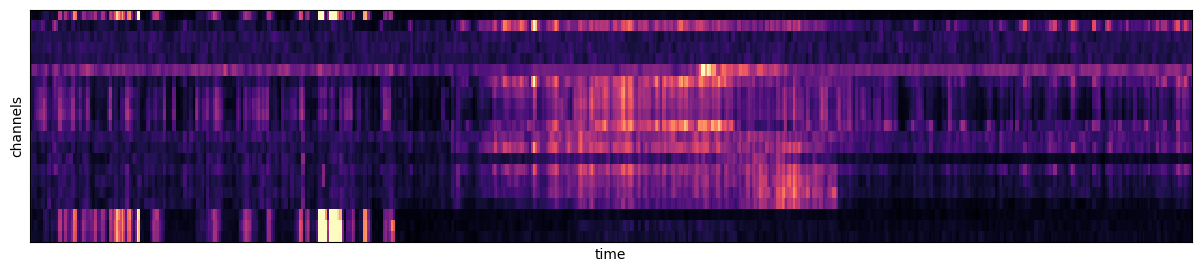

In [80]:
onset_idx = np.argmin(np.abs(sz_prob_times-onset_buffer))
offset_idx = np.argmin(np.abs(sz_prob_times - (np.max(sz_prob_times)-offset_buffer)))
plt.figure(figsize=(15, 3)) 
plt.matshow(sz_prob.loc[:,:].T,interpolation='none',fignum=1,aspect='auto',cmap = 'magma')
#plt.axvline(onset_idx,color='red',linewidth=3, label = 'actual onset');
#plt.axvline(offset_idx,color='blue',linewidth=3);
plt.xticks([]);
plt.yticks([]);
# plt.yticks(np.arange(sz_prob.shape[1]),sz_prob.columns)
plt.clim([np.min(sz_prob.values),4])
#plt.title('DSOSD')
plt.ylabel('channels')
plt.xlabel('time')
#plt.legend(loc='upper left')
plt.show()

## get threshold

In [81]:
threshold = model.get_bayesian_threshold(sz_prob.iloc[:,:])
print(f"The NDD ictal boundary is {threshold}")

# or select this as threshold
x = np.percentile(sz_prob.iloc[:onset_idx//2,:].to_numpy().flatten(),95)
print(x)

The NDD ictal boundary is 1.464420712908666
1.7681966


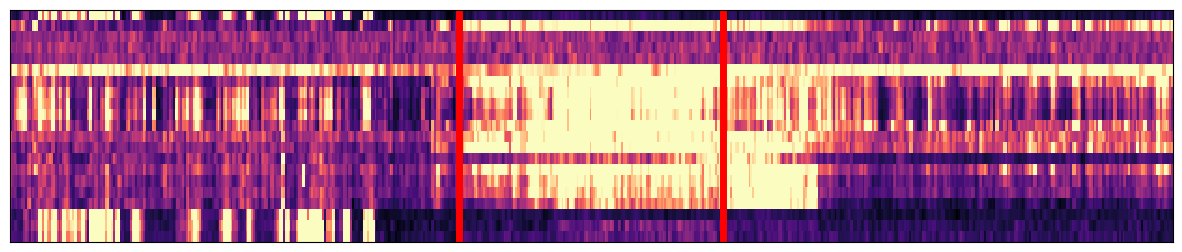

In [82]:
plt.figure(figsize=(15, 3))
plt.matshow(sz_prob.loc[:,:].T,interpolation='none',fignum=1,aspect='auto',cmap = 'magma')
plt.axvline(onset_idx,color='red',linewidth=5);
plt.axvline(offset_idx,color='red',linewidth=5);
plt.xticks([])
plt.yticks([])
plt.clim([np.min(sz_prob.values),threshold])

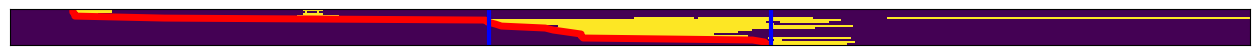

In [83]:
sz_spread,sz_clf_smooth, sz_idx = model.get_onset_and_spread(sz_prob.iloc[:,:], # Getting seiuzre onset and spread from the approximate onset and offset time
                                                     ret_smooth_mat=True, # Return matrix
                                                     rwin_size=10, # Sliding window for artifact rejection (Seconds)
                                                     rwin_req=7, # Required duration of positive detection in window (Seconds)
                                                     threshold=threshold # Threshold for detection
                                                    )
# Plot the seizure ictal wavefront after applying detection algorithm

plt.matshow(sz_clf_smooth.loc[:,sz_spread.columns].T,interpolation='none')
plt.plot(sz_spread.iloc[0,:],np.arange(sz_spread.shape[1]),color='red',linewidth=5)
plt.axvline(onset_idx,color='blue',linewidth=3)
plt.axvline(offset_idx,color='blue',linewidth=3) 
plt.yticks([])
plt.xticks([])
plt.show()

In [84]:
print(f"The seizure is detected to start {(np.mean(sz_spread.mean())-onset_idx)/2} seconds after clinician onset using mean")
print(f"The seizure is detected to start {(np.median(sz_spread.values)-onset_idx)/2} seconds after clinician onset using median")
sz_spread = sz_spread - np.min(sz_spread.min())
print(f"Onset channels are:\n {sz_spread.iloc[0,sz_spread.iloc[0,:].to_numpy() <=4].index}")
print(f"Onset times (s) are:\n {sz_prob_times[sz_spread.iloc[0,sz_spread.iloc[0,:].to_numpy() <=2]]}")

The seizure is detected to start -9.555555555555557 seconds after clinician onset using mean
The seizure is detected to start 8.5 seconds after clinician onset using median
Onset channels are:
 Index(['A01-A02', 'X15-X16', 'X17-X18', 'X16-X17'], dtype='object')
Onset times (s) are:
 [0.  0.  0.5 0.5]


# Perform on all data

In [91]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import sys
import os
from os.path import join as ospj
from tqdm import tqdm
import time
import sys
import warnings
from model_dsosd import NDD, NDDmodel
from utils_dsosd import get_iEEG_data, detect_bad_channels, preprocess_for_detection
if not sys.warnoptions:
    warnings.simplefilter("ignore")


#time_diff = []
def test_all(seizure_list, i):
    sz_row = seizure_list.iloc[i,:]
    onset_buffer, offset_buffer = 120,min(120,sz_row.postictal)
    start_time_us = (sz_row.onset - onset_buffer)*1e6
    stop_time_us = (sz_row.offset + offset_buffer)*1e6
    #print(f"Pulling seizure from {sz_row.patient}: {sz_row.fname} from {sz_row.onset} to {sz_row.offset}")
    sz_df, fs_raw = get_iEEG_data(ieeg_user,ieeg_pwd,sz_row.fname,start_time_us,stop_time_us)

    sz_df = pd.DataFrame(sz_df,columns=sz_df.columns)
    sz_df = sz_df.dropna()
    bad_ch_mask,info = detect_bad_channels(sz_df.loc[:fs_raw*onset_buffer/2,:].to_numpy(),fs_raw)
    sz_df_no_noisy = sz_df.loc[:,bad_ch_mask]
    if sz_df_no_noisy.shape[1]==0:
        return None, 0, None
    # preprocess seizure for detection algorithm
    sz_prep,fs = preprocess_for_detection(sz_df_no_noisy,fs_raw,'bipolar',target=256,pre_mask=[])
    if sz_prep is None:
        return None, 0, None
    else:
        # reject artifact laden channels based on preictal data 
        art_channel_mask = sz_prep.iloc[:int(onset_buffer*fs),:].abs().max() <= (np.median(sz_prep.iloc[:int(onset_buffer*fs),:].abs().max())*50)
        sz_nart = sz_prep.loc[:,art_channel_mask]
        model = NDD(model_class=NDDmodel,fs=256,w_size=1,w_stride=0.5)

        # fitting model to preictal window (-120 s to -60 seconds from seizure onset)
        model.fit(sz_nart.loc[:fs*onset_buffer/2,:])

        # generate seizure likelihood feature (NDD)
        sz_prob = model(sz_nart)
        sz_prob_times = model.get_win_times(len(sz_nart)) # seconds of pulled data
        onset_idx = np.argmin(np.abs(sz_prob_times-onset_buffer))
        offset_idx = np.argmin(np.abs(sz_prob_times - (np.max(sz_prob_times)-offset_buffer)))
        '''test with other thresholds'''
        x = np.percentile(sz_prob.iloc[:onset_idx//2,:].to_numpy().flatten(),95)
        threshold = model.get_bayesian_threshold(sz_prob.iloc[:,:])
        sz_spread,sz_clf_smooth, sz_idx = model.get_onset_and_spread(sz_prob.iloc[:,:], # Getting seiuzre onset and spread from the approximate onset and offset time
                                                            ret_smooth_mat=True, # Return matrix
                                                            rwin_size=10, # Sliding window for artifact rejection (Seconds)
                                                            rwin_req=7, # Required duration of positive detection in window (Seconds)
                                                            threshold=x # Threshold for detection
                                                            )
        #print(f"The seizure is detected to start {(np.mean(sz_spread.mean())-onset_idx)/2} seconds after clinician onset")
        #print('------------------------------------------------------------------------------')
        #time_diff.append((np.mean(sz_spread.mean())-onset_idx)/2)

        return (np.mean(sz_spread.mean())-onset_idx)/2, 1, np.array(np.mean(sz_idx,axis = 1))

In [93]:
import warnings
import time
from tqdm import tqdm
warnings.filterwarnings("ignore")

seizure_list = pd.read_csv('/mnt/sauce/littlab/users/kuangzy/SeizureOnsetDetection/revised_emu_seizure_sheet.csv')
print('total number of clips: ', len(seizure_list))
diff = []
sz_wins = []
for idx in tqdm(range(len(seizure_list))):
    difference, valid, sz_win = test_all(seizure_list,idx)
    if valid == 1:
        diff.append(difference)
        sz_wins.append(sz_win)
    else:
        diff.append(np.nan)
        sz_wins.append(np.array([]))
with open("diff_dsosd.txt", 'w') as f:
    for s in diff:
        f.write(str(s) + '\n')

total number of clips:  449


100%|██████████| 449/449 [1:26:02<00:00, 11.50s/it]


## Analysis

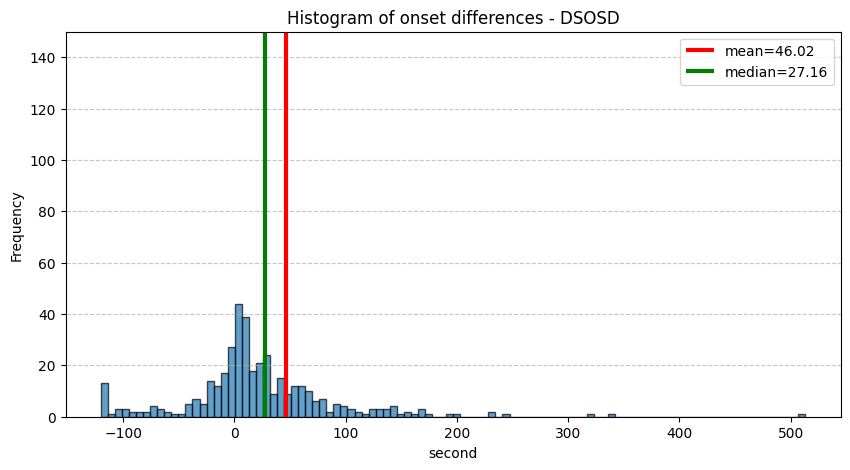

In [89]:
with open("diff_dsosd.txt", 'r') as f: 
    diff = [float(line.rstrip('\n')) for line in f]

def plot_histogram(data, bins, title="Histogram of onset differences - DSOSD", xlabel="second", ylabel="Frequency"):
    mean_value = np.nanmean(np.abs(data))
    median_value = np.nanmedian(np.abs(data))
    plt.figure(figsize=(10, 5))
    counts, bin_edges, _ = plt.hist(data, bins=bins, edgecolor="black", alpha=0.7)
    #plt.xticks(bin_edges)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.vlines(np.nanmean(np.abs(data)),0,150,colors='r', linewidth= 3,label=f'mean={mean_value:.2f}')
    plt.vlines(np.nanmedian(np.abs(data)),0,150,colors='g',linewidth= 3,label=f'median={median_value:.2f}')
    plt.legend()
    plt.ylim(0,150)
    plt.show()
    

# Example usage
plot_histogram(diff, bins=100)

Text(0.5, 1.0, 'Normalized Confusion Matrix of DSOSD')

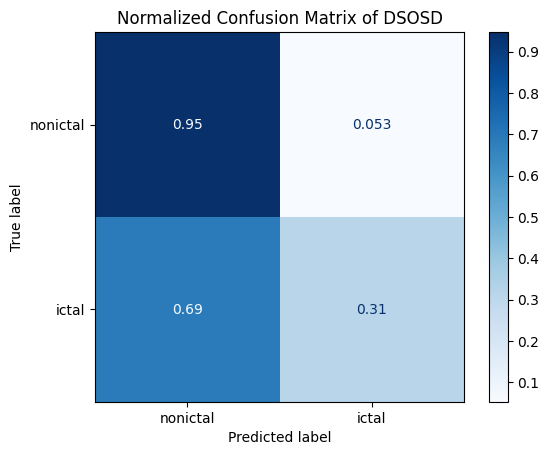

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true,predicted = [], []
for i in range(449):
    sz_row = seizure_list.iloc[i]
    onset_buffer, offset_buffer = 120,min(120,sz_row.postictal)

    start_time = (sz_row.onset - onset_buffer)
    stop_time = (sz_row.offset + offset_buffer)
    l = stop_time - start_time
    onset_idx = 120*2
    offset_idx = (l-offset_buffer)*2
    label = np.arange(sz_wins[i].shape[0])

    true += [1 if l <= offset_idx and l>=onset_idx else 0 for l in label]
    predicted += [1 if p>=0.35 else 0 for p in sz_wins[i]]

cm = confusion_matrix(true, predicted, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['nonictal','ictal'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix of DSOSD')